# Inventory Dynamics

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).


<a id='index-0'></a>

## Overview

This lecture explores the inventory dynamics of a firm using so-called s-S inventory control.

Loosely speaking, this means that the firm

- waits until inventory falls below some value $ s $  
- and then restocks with a bulk order of $ S $ units (or, in some models, restocks up to level $ S $).  


We will be interested in the distribution of the associated Markov process,
which can be thought of as cross-sectional distributions of inventory levels
across a large number of firms, all of which

1. evolve independently and  
1. have the same dynamics.  


Note that we also studied this model in a [separate
lecture](https://python.quantecon.org/inventory_dynamics.html), using Numba.

Here we study the same problem using JAX.

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax
from collections import namedtuple

Here’s a description of our GPU:

In [2]:
!nvidia-smi

Wed Mar 12 10:31:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample paths

Consider a firm with inventory $ X_t $.

The firm waits until $ X_t \leq s $ and then restocks up to $ S $ units.

It faces stochastic demand $ \{ D_t \} $, which we assume is IID across time and
firms.

With notation $ a^+ := \max\{a, 0\} $, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

Here’s a `namedtuple` that stores parameters.

In [3]:
Parameters = namedtuple('Parameters', ['s', 'S', 'μ', 'σ'])

# Create a default instance
params = Parameters(s=10, S=100, μ=1.0, σ=0.5)

## Cross-sectional distributions

Now let’s look at the marginal distribution $ \psi_T $ of $ X_T $ for some fixed $ T $.

The probability distribution $ \psi_T $ is the time $ T $ distribution of firm
inventory levels implied by the model.

We will approximate this distribution by

1. fixing $ n $ to be some large number, indicating the number of firms in the
  simulation,  
1. fixing $ T $, the time period we are interested in,  
1. generating $ n $ independent draws from some fixed distribution $ \psi_0 $ that gives the
  initial cross-section of inventories for the $ n $ firms, and  
1. shifting this distribution forward in time $ T $ periods, updating each firm
  $ T $ times via the dynamics described above (independent of other firms).  


We will then visualize $ \psi_T $ by histogramming the cross-section.

We will use the following code to update the cross-section of firms by one period.

In [4]:
@jax.jit
def update_cross_section(params, X_vec, D):
    """
    Update by one period a cross-section of firms with inventory levels given by
    X_vec, given the vector of demand shocks in D.

       * D[i] is the demand shock for firm i with current inventory X_vec[i]

    """
    # Unpack
    s, S = params.s, params.S
    # Restock if the inventory is below the threshold
    X_new = jnp.where(X_vec <= s,
                      jnp.maximum(S - D, 0), jnp.maximum(X_vec - D, 0))
    return X_new

### For loop version

Now we provide code to compute the cross-sectional distribution $ \psi_T $ given some
initial distribution $ \psi_0 $ and a positive integer $ T $.

In this code we use an ordinary Python `for` loop to step forward through time

While Python loops are slow, this approach is reasonable here because
efficiency of outer loops has far less influence on runtime than efficiency of inner loops.

(Below we will squeeze out more speed by compiling the outer loop as well as the
update rule.)

In the code below, the initial distribution $ \psi_0 $ takes all firms to have
initial inventory `x_init`.

In [5]:
def compute_cross_section(params, x_init, T, key, num_firms=50_000):
    # Set up initial distribution
    X_vec = jnp.full((num_firms, ), x_init)
      # 生成一个大小为 (50,000,) 的数组 X_vec，所有值为 x_init。
      # 代表 50,000 家公司的初始库存都设为 x_init。
    # Loop
    for i in range(T):
        Z = random.normal(key, shape=(num_firms, ))  # 生成 50,000 个标准正态随机数
        D = jnp.exp(params.μ + params.σ * Z)

        X_vec = update_cross_section(params, X_vec, D)
        _, key = random.split(key)
          # JAX 不支持 in-place 生成随机数，所以每次循环都需要手动更新随机种子。
          # random.split(key) 返回新的随机种子，确保每期的 Z 生成不同的随机数。

    return X_vec

We’ll use the following specification

In [6]:
x_init = 50
T = 500
# Initialize random number generator
key = random.PRNGKey(10)

Let’s look at the timing.

In [7]:
%time X_vec = compute_cross_section(params, \
        x_init, T, key).block_until_ready()

CPU times: user 1.72 s, sys: 282 ms, total: 2.01 s
Wall time: 1.6 s


Let’s run again to eliminate compile time.

In [8]:
%time X_vec = compute_cross_section(params, \
        x_init, T, key).block_until_ready()

CPU times: user 934 ms, sys: 277 ms, total: 1.21 s
Wall time: 714 ms


Here’s a histogram of inventory levels at time $ T $.

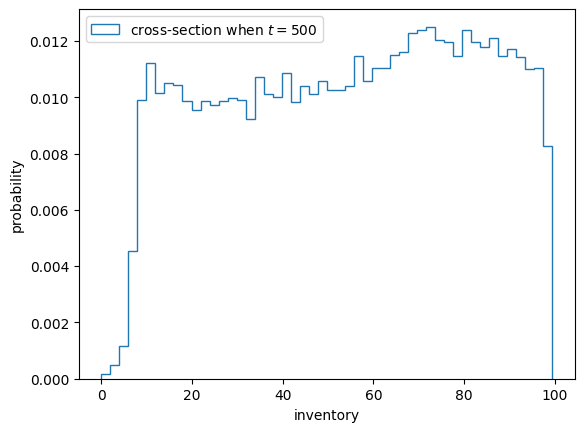

In [9]:
fig, ax = plt.subplots()
ax.hist(X_vec, bins=50,
        density=True,
        histtype='step',
        label=f'cross-section when $t = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

### Compiling the outer loop

Now let’s see if we can gain some speed by compiling the outer loop, which steps
through the time dimension.

We will do this using `jax.jit` and a `fori_loop`, which is a compiler-ready version of a `for` loop provided by JAX.

In [10]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)

    # Define the function for each update
    def fori_update(t, inputs):
        # Unpack
        X, key = inputs
        # Draw shocks using key
        Z = random.normal(key, shape=(num_firms,))
        D = jnp.exp(μ + σ * Z)
        # Update X
        X = jnp.where(X <= s,
                  jnp.maximum(S - D, 0),
                  jnp.maximum(X - D, 0))
        # Refresh the key
        key, subkey = random.split(key)
        return X, subkey

    # Loop t from 0 to T, applying fori_update each time.
    # The initial condition for fori_update is (X, key).
    X, key = lax.fori_loop(0, T, fori_update, (X, key))
      # 高效地执行 T 期循环，替代 Python for。
      # fori_update() 处理每个时间步的库存更新。
      # X, key 是 初始状态，fori_update() 反复作用在它们上。

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let’s see how fast this runs with compile time.

In [11]:
%time X_vec = compute_cross_section_fori(params, \
                x_init, T, key).block_until_ready()

CPU times: user 655 ms, sys: 23.7 ms, total: 679 ms
Wall time: 616 ms


And let’s see how fast it runs without compile time.

In [12]:
%time X_vec = compute_cross_section_fori(params, \
                x_init, T, key).block_until_ready()

CPU times: user 8.09 ms, sys: 1.79 ms, total: 9.88 ms
Wall time: 11.5 ms


Compared to the original version with a pure Python outer loop, we have
produced a nontrivial speed gain.

This is due to the fact that we have compiled the whole operation.

#### lax.fori_loop
## **1. `lax.fori_loop()` 是什么？**
`lax.fori_loop()` 是 **JAX 的一个高效循环函数**，用于 **替代 Python 的 `for` 循环**。  
它在 JAX 计算图（computation graph）中 **将整个循环优化为一个整体操作**，**避免 Python 解释器的逐步执行**，从而在 CPU/GPU/TPU 上运行更快。

在 JAX 中，`lax.fori_loop()` 的基本语法是：
```python
lax.fori_loop(lower, upper, body_fun, init_val)
```
- `lower`：循环起始值（相当于 `for i in range(lower, ...)`）。
- `upper`：循环终止值（不包含 `upper`）。
- `body_fun`：每次循环的计算函数（相当于 `for` 循环的循环体）。
- `init_val`：初始状态（循环开始时的变量）。

---

## **2. 为什么 `lax.fori_loop()` 比 Python `for` 快？**
### **🔹 (1) Python `for` 解释执行**
Python 的 `for` 循环 **每次迭代都会触发解释器运行代码**：
```python
for i in range(T):
    X = update(X)  # 逐步执行
```
- Python 是**逐行解释**，每次循环都要解析 `X = update(X)`。
- 在 `T=1000` 这样的多次迭代中，**解释器的开销很大**，导致运行慢。

---

### **🔹 (2) `lax.fori_loop()` 计算优化**
JAX 的 `lax.fori_loop()` **在编译时（JIT 编译）优化整个循环**：
```python
X_final = lax.fori_loop(0, T, update_function, X_init)
```
- **JAX 直接在计算图（computation graph）中展开整个循环**，**避免 Python 解释器的开销**。
- 计算图会**融合（fusion）所有循环操作**，让 GPU/TPU **批量计算**，**减少内存访问开销**。

---

## **3. `lax.fori_loop()` 例子**
### **🔹 (1) 普通 Python `for` 循环**
```python
import jax.numpy as jnp

X = jnp.array(0.0)  # 初始值

for i in range(10):
    X += 1
```
**问题**：
- **Python 解释器逐步执行**，每次循环都调用 `X += 1`，开销大。
- **JAX 需要 tracing `for` 循环**，无法完全优化。

---

### **🔹 (2) 用 `lax.fori_loop()` 计算相同的循环**
```python
from jax import lax

X_init = jnp.array(0.0)

def body_fun(i, X):
    return X + 1

X_final = lax.fori_loop(0, 10, body_fun, X_init)
```
**优化点**：
✅ **JAX 计算图优化**，整个 `fori_loop()` **被视为一个整体运算**。  
✅ **避免 Python 解释器干预**，执行更快。  
✅ **适用于 GPU/TPU**，提升大规模计算效率。  

---

## **4. 为什么 `lax.fori_loop()` 更适合大规模计算？**
### **🔹 (1) 支持 JAX 的 JIT 编译**
`lax.fori_loop()` 能和 `jax.jit()` 结合：
```python
@jax.jit
def compute():
    return lax.fori_loop(0, 1000, lambda i, x: x + 1, 0.0)
```
✅ **在编译时直接展开 `1000` 次循环**，计算更快。  
✅ **Python `for` 需要解释 `1000` 次，而 `fori_loop()` 直接在计算图上优化**。

---

### **🔹 (2) 避免 Python 的控制流**
**Python 的 `for` 循环无法完全 JIT 编译**，但 `lax.fori_loop()` 可以：
```python
@jax.jit
def slow_loop():
    X = jnp.array(0.0)
    for i in range(1000):  # 解释器逐步执行
        X += 1
    return X
```
**⚠️ Python `for` 不能高效 JIT 编译，影响速度**。

改用 `lax.fori_loop()`：
```python
@jax.jit
def fast_loop():
    return lax.fori_loop(0, 1000, lambda i, x: x + 1, 0.0)
```
**🚀 `lax.fori_loop()` 能被完全优化，速度更快！**



### Further vectorization

For relatively small problems, we can make this code run even faster by generating
all random variables at once.

This improves efficiency because we are taking more operations out of the loop.

In [13]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(T, num_firms))
    D = jnp.exp(μ + σ * Z)
#       预先生成 所有时间步 T 期的随机数 Z，并一次性计算所有 D[i, :]。
      # 好处：
      # 避免在 fori_loop 内部反复调用 random.normal()，减少 random.split() 的开销。
      # 计算 D 时，可以用 jnp.exp(μ + σ * Z) 并行计算，提升性能。
      # 潜在问题：
      # 由于所有随机数都是一次性生成的，如果 T 很大，可能会占用大量内存。
    def update_cross_section(i, X):
        X = jnp.where(X <= s,
                  jnp.maximum(S - D[i, :], 0),
                  jnp.maximum(X - D[i, :], 0))
        return X

    X = lax.fori_loop(0, T, update_cross_section, X)
      # fori_loop 仅作用于 X，每次迭代更新 X，不涉及 key 的变化。

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let’s test it with compile time included.

In [14]:
%time X_vec = compute_cross_section_fori(params, \
                x_init, T, key).block_until_ready()

CPU times: user 464 ms, sys: 10.4 ms, total: 475 ms
Wall time: 461 ms


Let’s run again to eliminate compile time.

In [15]:
%time X_vec = compute_cross_section_fori(params, \
                x_init, T, key).block_until_ready()

CPU times: user 5.9 ms, sys: 728 µs, total: 6.63 ms
Wall time: 6.82 ms


On one hand, this version is faster than the previous one, where random variables were
generated inside the loop.

On the other hand, this implementation consumes far more memory, as we need to
store large arrays of random draws.

The high memory consumption becomes problematic for large problems.

## Distribution dynamics

Next let’s take a look at how the distribution sequence evolves over time.

We will go back to using ordinary Python `for` loops.

Here is code that repeatedly shifts the cross-section forward while
recording the cross-section at the dates in `sample_dates`.

In [16]:
def shift_forward_and_sample(x_init, params, sample_dates,
                        key, num_firms=50_000, sim_length=750):

    X = res = jnp.full((num_firms, ), x_init)

    # Use for loop to update X and collect samples
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)

        X = update_cross_section(params, X, D)
        _, key = random.split(key)

        # draw a sample at the sample dates
        if (i+1 in sample_dates):
          res = jnp.vstack((res, X))
            # i+1（即当前时间步，从 1 开始计数）如果在 sample_dates 中：
            # 追加 X 到 res（行方向堆叠）
            # jnp.vstack() 生成新的数组，将 X 作为新的一行添加到 res

    return res[1:]
      # res 的第一行是 x_init，去掉它，只返回采样点数据


Let’s test it

In [17]:
x_init = 50
num_firms = 10_000
sample_dates = 10, 50, 250, 500, 750
key = random.PRNGKey(10)


%time X = shift_forward_and_sample(x_init, params, \
                    sample_dates, key).block_until_ready()

CPU times: user 1.81 s, sys: 324 ms, total: 2.14 s
Wall time: 1.47 s


We run the code again to eliminate compile time.

In [18]:
%time X = shift_forward_and_sample(x_init, params, \
                    sample_dates, key).block_until_ready()

CPU times: user 1.63 s, sys: 326 ms, total: 1.96 s
Wall time: 1.55 s


Let’s plot the output.

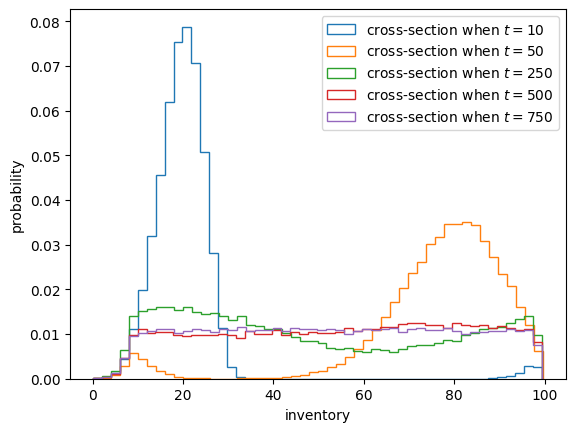

In [19]:
fig, ax = plt.subplots()

for i, date in enumerate(sample_dates):
    ax.hist(X[i, :], bins=50,
            density=True,
            histtype='step',
            label=f'cross-section when $t = {date}$')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

This model for inventory dynamics is asymptotically stationary, with a unique
stationary distribution.

In particular, the sequence of marginal distributions $ \{\psi_t\} $
converges to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can see it in the simulation above.

By $ t=500 $ or $ t=750 $ the distributions are barely changing.

If you test a few different initial conditions, you will see that they do not affect long-run outcomes.

## Restock frequency

As an exercise, let’s study the probability that firms need to restock over a given time period.

In the exercise, we will

- set the starting stock level to $ X_0 = 70 $ and  
- calculate the proportion of firms that need to order twice or more in the first 50 periods.  


This proportion approximates the probability of the event when the sample size
is large.

### For loop version

We start with an easier `for` loop implementation

In [20]:
# Define a jitted function for each update
@jax.jit
def update_stock(n_restock, X, params, D):
    n_restock = jnp.where(X <= params.s,
                          n_restock + 1,
                          n_restock)
    X = jnp.where(X <= params.s,
                  jnp.maximum(params.S - D, 0),
                  jnp.maximum(X - D, 0))
    return n_restock, X, key

def compute_freq(params, key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)

    # Stack the restock counter on top of the inventory
    n_restock = jnp.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        n_restock, X, key = update_stock(
            n_restock, X, params, D)
        key = random.fold_in(key, i)

    return jnp.mean(n_restock > 1, axis=0)

In [21]:
key = random.PRNGKey(27)

%time freq = compute_freq(params, key).block_until_ready()

CPU times: user 988 ms, sys: 58.8 ms, total: 1.05 s
Wall time: 1.11 s


We run the code again to get rid of compile time.

In [23]:
%time freq = compute_freq(params, key).block_until_ready()

CPU times: user 138 ms, sys: 29.1 ms, total: 167 ms
Wall time: 102 ms


In [22]:
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.44772300124168396


### Exercise 5.1

Write a `fori_loop` version of the last function.  See if you can increase the
speed while generating a similar answer.

### Solution to[ Exercise 5.1](https://jax.quantecon.org/#inventory_dynamics_ex1)

Here is a `lax.fori_loop` version that JIT compiles the whole function

In [24]:
@jax.jit
def compute_freq(params, key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(sim_length, num_firms)) #预先生成 T × num_firms 个 Z 并计算 D
    D = jnp.exp(μ + σ * Z)

    # Stack the restock counter on top of the inventory
    restock_count = jnp.zeros((num_firms, ))
    Xs = (X, restock_count)

    # Define the function for each update
    def update_cross_section(i, Xs):
        # Separate the inventory and restock counter
        x, restock_count = Xs[0], Xs[1]
        restock_count = jnp.where(x <= s,
                                restock_count + 1,
                                restock_count)
        x = jnp.where(x <= s,
                      jnp.maximum(S - D[i], 0),
                      jnp.maximum(x - D[i], 0))

        Xs = (x, restock_count)
        return Xs

    # Use lax.fori_loop to perform the calculations on all states
    X_final = lax.fori_loop(0, sim_length, update_cross_section, Xs)

    return jnp.mean(X_final[1] > 1)

Note the time the routine takes to run, as well as the output

In [25]:
%time freq = compute_freq(params, key).block_until_ready()

CPU times: user 533 ms, sys: 14.7 ms, total: 548 ms
Wall time: 529 ms


We run the code again to eliminate the compile time.

In [26]:
%time freq = compute_freq(params, key).block_until_ready()

CPU times: user 1.82 ms, sys: 987 µs, total: 2.81 ms
Wall time: 9.51 ms


In [27]:
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.4476909935474396
